In [ ]:
#remove warnings from displaying in output 
import warnings 
warnings.filterwarnings('ignore')

# importing the required libraries 
import os 
import re 
import nltk
import cv2
import time
import datetime
nltk.download('stopwords')
nltk.download('punkt')
from bs4 import BeautifulSoup
from PIL import Image
from skimage.transform import resize
from nltk.corpus import stopwords
from nltk import word_tokenize
from os import listdir
from os import path
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm import tqdm
from wordcloud import WordCloud, ImageColorGenerator
from sklearn.model_selection import train_test_split
import nltk.translate.bleu_score as bleu
from google.colab.patches import cv2_imshow
from PIL import Image
import xml.etree.ElementTree as ET

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
tf.keras.backend.clear_session()
from tensorflow.keras.models import Model
from tensorflow.keras.applications import densenet
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications.densenet import preprocess_input

from tensorflow.keras import layers 
from tensorflow.keras.layers import Dense,Input,Conv2D,MaxPool2D,Activation,Dropout
from tensorflow.keras.layers import LSTM,Embedding,Flatten,BatchNormalization,ReLU
from tensorflow.keras.layers import Softmax,RNN,Reshape,concatenate,TimeDistributed

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df=pd.read_csv('/content/drive/MyDrive/final_df.csv')
df.head()

,images,impression
0,"CXR58_IM-2177-2001.png,CXR58_IM-2177-1001.png",No acute disease
1,"CXR575_IM-2173-2001.png,CXR575_IM-2173-1001.png",No acute cardiopulmonary abnormalities
2,"CXR600_IM-2192-2001.png,CXR600_IM-2192-1001.png",Negative for acute abnormality
3,"CXR587_IM-2182-1001.png,CXR587_IM-2182-2001.png",No interval change in the appearance of the o...
4,"CXR587_IM-2182-3001.png,CXR587_IM-2182-2001.png",No interval change in the appearance of the o...


In [ ]:
df.shape

(4065, 2)

In [ ]:
df['len'] = df['impression'].apply(lambda x : len(x.split()))

In [ ]:
df['len'].describe()

count    4065.000000
mean        9.924969
std        11.291547
min         1.000000
25%         4.000000
50%         5.000000
75%        11.000000
max       123.000000
Name: len, dtype: float64

In [ ]:
max_length=int(np.percentile(df['len'],100))
print('100 percent of impressions has word length less that or equal to : ',max_length)

100 percent of impressions has word length less that or equal to :  123


In [ ]:
df = df.drop(columns=['len'],axis=1)

In [ ]:
imp_inp = []
imp_out = []
for i in range(len(df['impression'])):
  imp_inp.append('<start> '+df['impression'][i]) 
  imp_out.append(df['impression'][i] + ' <end>')
  df['impression'][i]= '<start> ' +df['impression'][i] + ' <end>'

In [ ]:
print('ORIGINAL SEQUENCE:  ',df['impression'][1])
print('INPUT SEQUENCE:  ',imp_inp[1])
print('OUTPUT_SEQUENCE:  ',imp_out[1])

ORIGINAL SEQUENCE:   <start> No acute cardiopulmonary abnormalities  <end>
INPUT SEQUENCE:   <start> No acute cardiopulmonary abnormalities 
OUTPUT_SEQUENCE:   No acute cardiopulmonary abnormalities  <end>


### Tokenizer

In [ ]:
tokenizer = Tokenizer(oov_token='<unk>',split=' ',lower=True,filters='')

tokenizer.fit_on_texts(df['impression'])

target_vocab_size = len(tokenizer.word_index)+1

target_inp = tokenizer.texts_to_sequences(imp_inp)

target_out = tokenizer.texts_to_sequences(imp_out)

target_inp = pad_sequences(target_inp,maxlen=max_length,padding='post')

target_out = pad_sequences(target_out,maxlen=max_length,padding='post')

### Splitting the data into train test validation 

In [ ]:
img_name_train, img_name_temp, target_train_inp, target_temp_inp,target_train_out,target_temp_out = train_test_split(df['images'].values,
                                                                target_inp,target_out,test_size=0.10,random_state=0,shuffle=True)

img_name_val, img_name_test, target_val_inp, target_test_inp,target_val_out,target_test_out = train_test_split(img_name_temp,
                                                                target_temp_inp,target_temp_out,test_size=0.019,random_state=0,shuffle=True)

### Defining parameters 

In [ ]:
img_height = 224
img_width = 224

BATCH_SIZE = 7 
embedding_dim = 256 
units = 512
rate = 0.1
input_len_dec = target_val_inp.shape[1]
attention_features_shape = 49

### Different augmentation 

In [ ]:
import imgaug.augmenters as iaa
aug2 = iaa.Fliplr(1)
aug3 = iaa.Flipud(1)
aug4 = iaa.Emboss(alpha=(1), strength=1)
aug5 = iaa.DirectedEdgeDetect(alpha=(0.8), direction=(1.0))
aug6 = iaa.Sharpen(alpha=(1.0), lightness=(1.5))

In [ ]:
# segmentation assignment

def load_image(image,training = True):
    
    img = tf.io.read_file(image)
    img = tf.image.decode_jpeg(img, channels=3)
    image = tf.image.resize(img, (int(img_height),int(img_width)))
    
    if training == True:
      a = np.random.uniform()
      if a<0.2:
              image = aug2.augment_image(image)
      elif a<0.4:
              image = aug3.augment_image(image)
      elif a<0.6:
              image = aug4.augment_image(image)
      elif a<0.8:
              image = aug5.augment_image(image)
      else:
              image = aug6.augment_image(image)  
    image = preprocess_input(image)
    return image

In [ ]:
# segmentation assignment
class Dataloder(tf.keras.utils.Sequence):    

    def __init__(self, image_names,capin,capout, batch_size=1, shuffle=False):
        self.image_names = image_names
        self.capin = capin
        self.capout = capout
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(image_names))
        
    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        image1 =[]
        image2 = []
        caption_in = []
        caption_out = []
  
        for j in range(start, stop):
            img,img1 = self.__data_generation(self.image_names[j])
            image1.append(img)
            image2.append(img1)
            caption_in.append(self.capin[j]) 
            caption_out.append(self.capout[j])
        return tuple([(tf.convert_to_tensor(image1),tf.convert_to_tensor(image2),tf.convert_to_tensor(caption_in)),(tf.convert_to_tensor(caption_out))])
    
    def __len__(self):
        return len(self.indexes) // self.batch_size 

    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

    def __data_generation(self,image_name):
        image_name = image_name.split(',')
        
        image1 = load_image(image_path+image_name[0])
        image2 = load_image(image_path+image_name[1])
        
        return image1,image2

In [ ]:
train_dataloader = Dataloder(img_name_train, target_train_inp,target_train_out, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = Dataloder(img_name_val, target_val_inp,target_val_out, batch_size=BATCH_SIZE, shuffle=True)

## Transfer Learning using chexNet to extract image features . 

CheXNet is a 121-layer convolution neural network trained on ChestX-ray14 which cotains 100000 frontal view X-Ray images to classify it into 14 diseases. 
We are using the CheXNet to extract image features from the X-Ray images. We are not Training the CheXNet from Scratch we are loading the weights of pretrained model. That is we are performing Transfer Learning .

One can Read more about ChexNet [here](https://arxiv.org/pdf/1711.05225.pdf)

In [ ]:
#https://github.com/brucechou1983/CheXNet-Keras
# weigths : https://drive.google.com/file/d/19BllaOvs2x5PLV_vlWMy4i8LapLb2j6b/view 

model = tf.keras.applications.DenseNet121(weights=None,classes = 14,input_shape=(int(img_width),int(img_height),3))

# classes is 14 because its trained on 14 classes classification (multi class classification)
model.load_weights('/content/drive/My Drive/brucechou1983_CheXNet_Keras_0.3.0_weights.h5')

image_features_extract_model = Model(inputs=model.input,outputs=model.layers[-3].output)

In [ ]:
image_features_extract_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
image_path = '/content/drive/MyDrive/NLMCXR_png/'

### Encoder

In [ ]:
# seq to seq assignment .
class Encoder(tf.keras.layers.Layer):
    
    def __init__(self, embedding_dim,feature_extracter):
        super(Encoder, self).__init__()
        self.image_features_extract_model = feature_extracter
    
    def call(self, x):
        x = image_features_extract_model(x)
        x = tf.reshape(x,(x.shape[0], -1, x.shape[3]))
        return x

### Attention Layer

In [ ]:
#https://www.tensorflow.org/tutorials/text/nmt_with_attention
class attention_concat(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
    
    def call(self,decoder_hidden_state,encoder_output_states):
        decoder_hidden_state = tf.expand_dims(decoder_hidden_state, 1)
        similarities = self.V(tf.nn.tanh(self.W1(decoder_hidden_state) + self.W2(encoder_output_states)))
        attention_weights = tf.nn.softmax(similarities, axis=1)
        context_vector = attention_weights * encoder_output_states
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

### Decoder

In [ ]:
# https://sezazqureshi.medium.com/chest-x-ray-medical-report-generation-using-deep-learning-bf39cc487b88
# https://www.tensorflow.org/tutorials/text/image_captioning

class Decoder(tf.keras.Model):
    def __init__(self,out_vocab_size, embedding_dim, input_length, dec_units ,atten_layer):
        super(Decoder, self).__init__()
        self.out_vocab_size = out_vocab_size
        self.embedding_dim = embedding_dim
        self.dec_units = dec_units
        self.attention = atten_layer
        self.input_length = input_length

        self.embedding = Embedding(input_dim = self.out_vocab_size, output_dim = self.embedding_dim, input_length = self.input_length,
                           mask_zero=True, name="embedding_layer_decoder")
        
        self.lstm = LSTM(self.dec_units, return_sequences=True, return_state=True, name="Decoder_LSTM",dropout=rate,recurrent_dropout=rate)
    
        self.fc = Dense(self.out_vocab_size)

    @tf.function
    def onestep_decoder(self,input_to_decoder, state_h, encoder_output , state_c):
        '''one step decoder is called for every timestamp'''
        target_embedd  = self.embedding(input_to_decoder)

        context_vector,attention_weights = self.attention(state_h,encoder_output)

        context_vector = tf.expand_dims(context_vector,1)

        concat = tf.keras.layers.Concatenate(axis=-1)([target_embedd,context_vector])

        concat = tf.nn.dropout(concat, rate)

        lstm_out, state_h, state_c = self.lstm(concat,initial_state=(state_h,state_c))

        lstm_out = tf.reshape(lstm_out,(-1,lstm_out.shape[2]))

        output = self.fc(lstm_out)

        return output , state_h , attention_weights , state_c

    def call(self, input_to_decoder,decoder_hidden_state,encoder_output,decoder_cell_state ):
        all_outputs = tf.TensorArray(tf.float32 , size=input_to_decoder.shape[1] , name = 'output_arrays')
        for timestep in range(input_to_decoder.shape[1]):
            output , decoder_hidden_state ,attn_weights, decoder_cell_state  = self.onestep_decoder(input_to_decoder[:,timestep:timestep+1] ,
                                                            decoder_hidden_state ,encoder_output,decoder_cell_state)
            
            all_outputs = all_outputs.write(timestep,output)
        all_outputs = tf.transpose(all_outputs.stack() , [1,0,2])
        return all_outputs

    def reset_hidden_state(self, batch_size):
      return tf.random.normal((batch_size, self.dec_units))

    def reset_cell_state(self,batch_size):
      return tf.random.normal((batch_size,self.dec_units))

### Custom Loss

In [ ]:
# seq seq assigment 
optimizer = tf.keras.optimizers.Adam(0.00001)

def loss_function(targets, logits):

    '''custom loss which considers only non zeros in the targets'''

    crossentropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    mask = tf.math.logical_not(tf.math.equal(targets, 0))
    mask = tf.cast(mask, dtype=tf.int64)
    loss = crossentropy(targets, logits, sample_weight=mask)
    return loss

In [ ]:
# defining 
CNN_Encoder = Encoder(embedding_dim,image_features_extract_model)
decoder = Decoder(target_vocab_size, embedding_dim, input_len_dec,units,attention_concat())

In [ ]:
tr_loss_plot = []
val_loss_plot = []

## Training 

In [ ]:
@tf.function
def train_step(inputs, target):
    loss = 0
    image1,image2,input_text = inputs[0],inputs[1],inputs[2]    
    hidden = decoder.reset_hidden_state(batch_size=BATCH_SIZE)
    cell_state = decoder.reset_cell_state(batch_size=BATCH_SIZE)
        
    with tf.GradientTape() as tape:
        encoder_output_1 = CNN_Encoder(image1)
        encoder_output_2 = CNN_Encoder(image2)
        encoder_output = tf.keras.layers.Concatenate(axis=-1)([encoder_output_1,encoder_output_2])
        encoder_output = Dropout(rate)(encoder_output)
        decoder_output = decoder(input_text,hidden,encoder_output,cell_state)

        for i in range(decoder_output.shape[1]):
            loss += loss_function(target[:, i], decoder_output[:,i])

        total_loss = loss/int(decoder_output.shape[1])
        trainable_variables = CNN_Encoder.trainable_variables + decoder.trainable_variables 
        gradients = tape.gradient(loss,trainable_variables)
        optimizer.apply_gradients(zip(gradients,trainable_variables))

        return loss,total_loss


In [ ]:
@tf.function

def validation_step(inputs, target):
    loss = 0
    image1,image2,input_text = inputs[0],inputs[1],inputs[2]
    hidden = decoder.reset_hidden_state(batch_size=BATCH_SIZE)
    cell_state = decoder.reset_cell_state(batch_size=BATCH_SIZE)    
    encoder_output_1 = CNN_Encoder(image1)
    encoder_output_2 = CNN_Encoder(image2)
    encoder_output = tf.keras.layers.Concatenate(axis=-1)([encoder_output_1,encoder_output_2])
    decoder_output = decoder(input_text,hidden,encoder_output,cell_state)
    for i in range(decoder_output.shape[1]):
        loss += loss_function(target[:, i], decoder_output[:,i])
    total_loss = loss/int(target.shape[1])
    
    return  loss,total_loss

In [ ]:
EPOCHS = 15

for epoch in range(0,EPOCHS):
    total_loss_train = 0
    total_loss_val = 0

    for (batch,(inputs,target)) in (enumerate(train_dataloader)):
        batch_loss,t_loss = train_step(inputs,target)
        total_loss_train+=t_loss

    for (batch,(inputs,target)) in (enumerate(val_dataloader)):
        batch_loss,t_loss = validation_step(inputs,target)
        total_loss_val+=t_loss

    tr_loss_plot.append((total_loss_train/int(len(img_name_train) // BATCH_SIZE)).numpy())
    val_loss_plot.append((total_loss_val/int(len(img_name_val)//BATCH_SIZE)).numpy())

    train_dataloader.on_epoch_end()
    val_dataloader.on_epoch_end()

    print('Epoch {}/{}'.format(epoch+1,EPOCHS))

    print ('[==============================] - loss : {}  -  val_loss : {}'.format(total_loss_train/ int(len(img_name_train) // BATCH_SIZE), 
                                                                        total_loss_val/int(len(img_name_val) // BATCH_SIZE)))
  
    if (len(val_loss_plot)>3) and val_loss_plot[-1] > np.asarray(val_loss_plot[-3]):
        new_learning_rate = 0.1*optimizer.lr.numpy()
        print('Reducing the  learning rate from {:.7f} to {:.7f} :'.format(optimizer.lr.numpy(),new_learning_rate))
        optimizer.lr.assign(new_learning_rate)

    if (len(val_loss_plot)>6) and val_loss_plot[-1] > np.asarray(val_loss_plot[-6]):
        print('stopping due to no change in validation loss')
        break

Epoch 1/15
[==============================] - loss : 0.5329304337501526  -  val_loss : 0.46901628375053406
Epoch 2/15
[==============================] - loss : 0.46643999218940735  -  val_loss : 0.44414761662483215
Epoch 3/15
[==============================] - loss : 0.4500662088394165  -  val_loss : 0.4320763945579529
Epoch 4/15
[==============================] - loss : 0.4403628408908844  -  val_loss : 0.4250514805316925
Epoch 5/15
[==============================] - loss : 0.43407827615737915  -  val_loss : 0.4187336564064026
Epoch 6/15
[==============================] - loss : 0.4277839660644531  -  val_loss : 0.4138586223125458
Epoch 7/15
[==============================] - loss : 0.42328742146492004  -  val_loss : 0.4106866121292114
Epoch 8/15
[==============================] - loss : 0.41964372992515564  -  val_loss : 0.4072646498680115
Epoch 9/15
[==============================] - loss : 0.4162079989910126  -  val_loss : 0.40423640608787537
Epoch 10/15
[==========================

In [ ]:
checkpoint_path = "/content/drive/My Drive/checkpoint"
ckpt = tf.train.Checkpoint(encoder=CNN_Encoder,decoder=decoder,optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
ckpt_manager.save()

'/content/drive/My Drive/checkpoint/ckpt-1'

## Plotting loss values


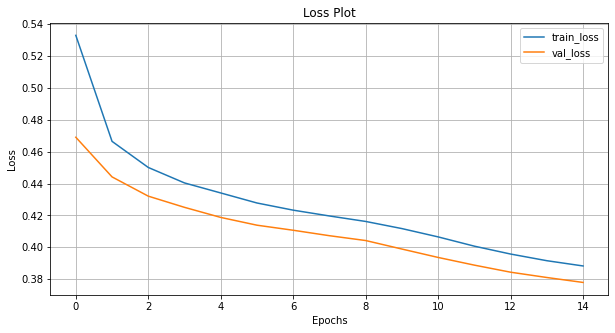

In [ ]:
plt.figure(figsize = (10,5))
plt.plot(tr_loss_plot,label='train_loss')
plt.plot(val_loss_plot,label = 'val_loss')
plt.legend()
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Inference

In [ ]:
def evaluate(image_path):
    attention_plot = np.zeros((input_len_dec, attention_features_shape))
    encoder_output_1 = CNN_Encoder(image_path[0])
    encoder_output_2 = CNN_Encoder(image_path[1])
    encoder_output = tf.keras.layers.Concatenate(axis=-1)([encoder_output_1,encoder_output_2])
    hidden = decoder.reset_hidden_state(batch_size=1)
    cell_state = decoder.reset_cell_state(batch_size=1)
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(input_len_dec):
        predictions,hidden,attention_weights,cell_state=decoder.onestep_decoder(dec_input,hidden,encoder_output, cell_state)
        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])
        if tokenizer.index_word[predicted_id] == '<end>':
            attention_plot = attention_plot[:len(result), :]

            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)
    attention_plot = attention_plot[:len(result), :]

    return result, attention_plot

In [ ]:
def load_img(image_path):
    image_path = image_path.split(',')
    img1 = load_image('/content/drive/MyDrive/NLMCXR_png/'+image_path[0],training = False)
    img2 = load_image('/content/drive/MyDrive/NLMCXR_png/'+image_path[1],training = False)
    img1 = tf.expand_dims(img1, axis=0)
    img2 = tf.expand_dims(img2, axis=0)
    return (img1,img2)

In [ ]:
def remove_tok(sentence):
  clean_sent = ''
  for i in sentence.split():
      if i == "<start>" or i == "<end>":
        continue
      else:
        clean_sent+= "".join(i+" ")
  return clean_sent.strip()

In [ ]:
def plot_attention(image, result, attention_plot):
    image = image.split(',')
    res_image1 = Image.open('/content/drive/MyDrive/NLMCXR_png/'+image[0])
    res_image2 = Image.open('/content/drive/MyDrive/NLMCXR_png/'+image[1])

    dst = Image.new('RGB', (res_image1.width + res_image2.width, res_image1.height))
    dst.paste(res_image1, (0, 0))
    dst.paste(res_image2, (res_image1.width, 0))

    fig = plt.figure(figsize=(20, 20))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (7, 7))
        ax = fig.add_subplot(len_result//2+1, len_result//2+1, l+1)
        ax.set_title(result[l])
        img1 = ax.imshow(dst)
        ax.imshow(temp_att, cmap='Greys', alpha=0.6, extent=img1.get_extent())
    plt.tight_layout()
    plt.show()

### Plotting random Attention plots 

Acutal caption: no active disease
predicted caption: no acute cardiopulmonary active


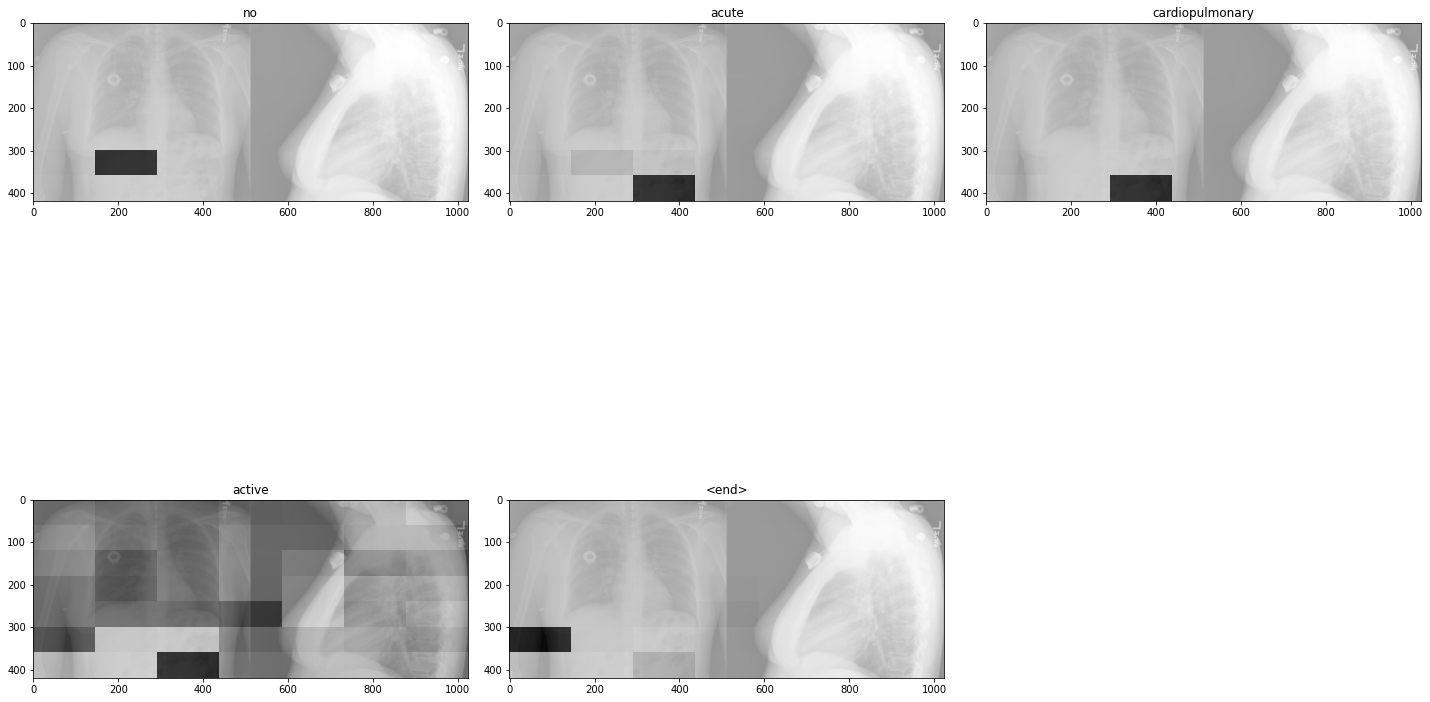

In [ ]:
random_id = np.random.randint(0, len(img_name_test))
image = load_img( img_name_test[random_id])

result, attention_plot = evaluate(image)
actual = []

for i in target_test_out[random_id]:
  if tokenizer.index_word[i] == '<end>':
    break
  else:
    actual.append(tokenizer.index_word[i])

print ('Acutal caption:', ' '.join(actual))
print ('predicted caption:', ' '.join(result[:-1]))
plot_attention(img_name_test[random_id], result, attention_plot)

Acutal caption: no acute cardiopulmonary findings
predicted caption: for size of volumes disease of effusion no acute disease


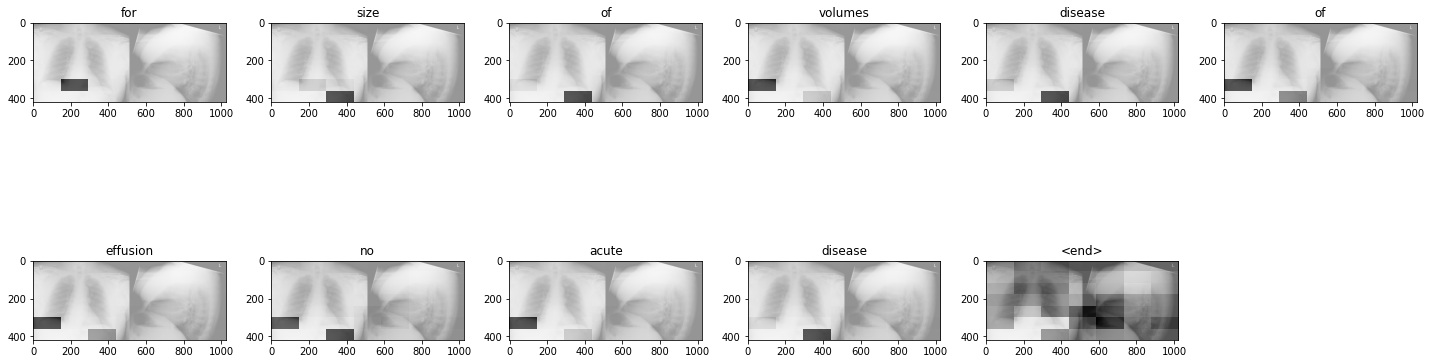

In [ ]:
random_id = np.random.randint(0, len(img_name_test))
image = load_img( img_name_test[random_id])

result, attention_plot = evaluate(image)
actual = []

for i in target_test_out[random_id]:
  if tokenizer.index_word[i] == '<end>':
    break
  else:
    actual.append(tokenizer.index_word[i])
    
print ('Acutal caption:', ' '.join(actual))
print ('predicted caption:', ' '.join(result[:-1]))
plot_attention(img_name_test[random_id], result, attention_plot)

Acutal caption: no acute cardiopulmonary findings
predicted caption: no acute cardiopulmonary finding


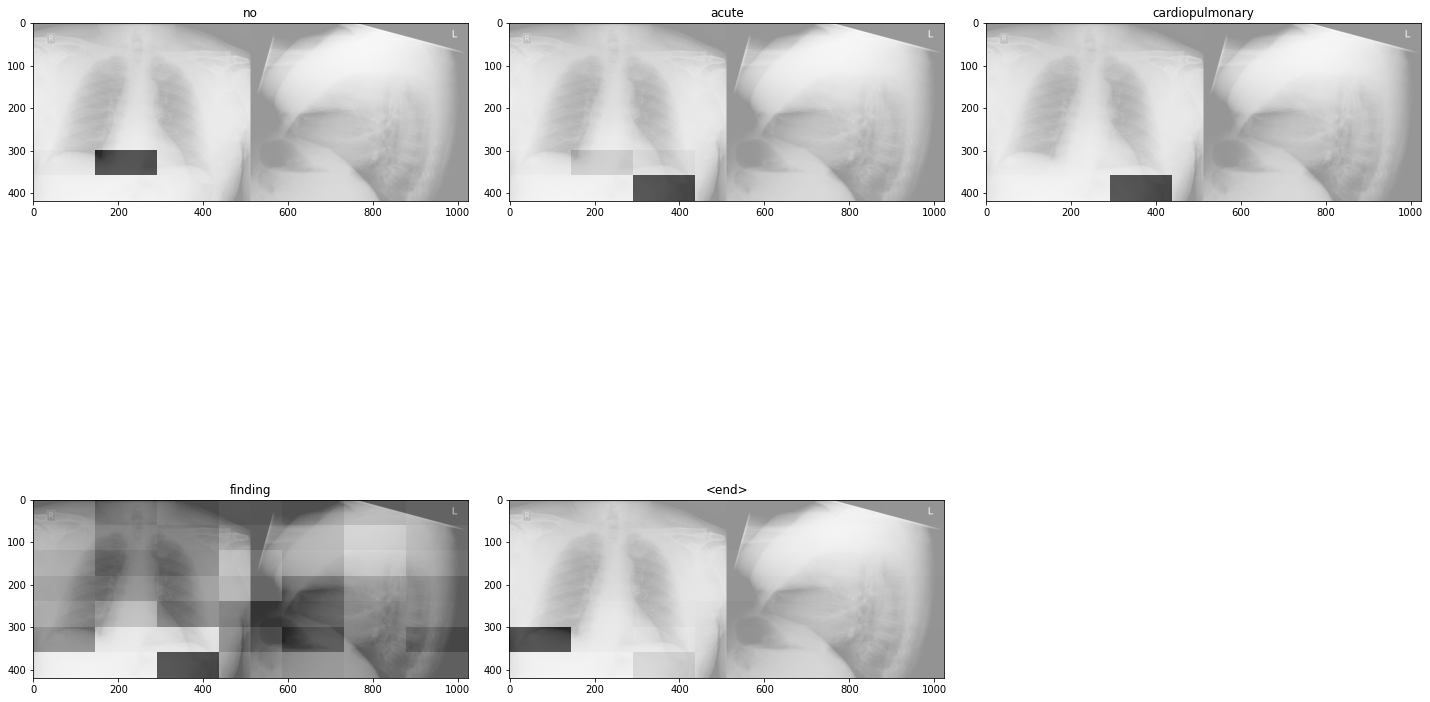

In [ ]:
random_id = np.random.randint(0, len(img_name_test))
image = load_img( img_name_test[random_id])

result, attention_plot = evaluate(image)
actual = []

for i in target_test_out[random_id]:
  if tokenizer.index_word[i] == '<end>':
    break
  else:
    actual.append(tokenizer.index_word[i])
    
print ('Acutal caption:', ' '.join(actual))
print ('predicted caption:', ' '.join(result[:-1]))
plot_attention(img_name_test[random_id], result, attention_plot)

## Calculating BLEU score for overall data 

In [ ]:
#http://www.nltk.org/api/nltk.translate.html#nltk.translate.bleu_score.sentence_bleu

def compute_bleu_score(sentence,result):

  reference = remove_tok(sentence)
  translation = remove_tok(result)

  bleu_1 =  bleu.sentence_bleu([reference.split()], translation.split(), weights=(1, 0, 0, 0))
  bleu_2 = bleu.sentence_bleu([reference.split()], translation.split(), weights=(0.5, 0.5, 0, 0))
  bleu_3 = bleu.sentence_bleu([reference.split()], translation.split(), weights=(0.33, 0.33, 0.33, 0))
  bleu_4 =  bleu.sentence_bleu([reference.split()], translation.split(), weights=(0.25, 0.25, 0.25, 0.25))

  return bleu_1,bleu_2,bleu_3,bleu_4

def compute_score(image):
  result, attention_weights = evaluate(image)
  actual = []
  for i in sentence_in.numpy()[0]:
    if tokenizer.index_word[i] == '<end>':
      break
    else:
      actual.append(tokenizer.index_word[i])

  score = compute_bleu_score(' '.join(actual), ' '.join(result[:-1]))
  return score

In [ ]:
evaluate_dataloader = Dataloder(df['images'].values,target_inp,target_out, batch_size=1, shuffle=False)

In [ ]:
len(evaluate_dataloader)

4065

In [ ]:
bleu1_final = 0
bleu2_final = 0
bleu3_final = 0
bleu4_final = 0

for (batch,(inputs,target)) in tqdm(enumerate(evaluate_dataloader)):
  score1,score2,score3,score4 = compute_score(inputs)
  bleu1_final+=score1
  bleu2_final+=score2
  bleu3_final+=score3
  bleu4_final+=score4

4065it [24:17,  2.79it/s]


In [ ]:
final_bleu1 =bleu1_final/ len(evaluate_dataloader)
print('BLEU Score of unigrams',final_bleu1)

final_bleu2 =bleu2_final/ len(evaluate_dataloader)
print('BLEU Score of bigrams',final_bleu2)

final_bleu3 =bleu3_final/ len(evaluate_dataloader)
print('BLEU Score of trigrams',final_bleu3)

final_bleu4 =bleu4_final/ len(evaluate_dataloader)
print('BLEU Score of tetragrams',final_bleu4)

BLEU Score of unigrams 0.16597623776914933
BLEU Score of bigrams 0.2316479974378329
BLEU Score of trigrams 0.2960501791602742
BLEU Score of tetragrams 0.3422173843434533


### Conculsion : 

Firstly we extracted all the required fields from xml data . As the number of images in each datapoint is different we have formed dataset in such a way it contains 2 images for every datapoint dropping the datapoints which have zero images.

Preprocess the required text columns and performed EDA on the obtained data. 

We have used transfer learning on chex net to extract the image features(which is considered as out encoder for our model). 

We then tokenize the target(impression column) and passed it as input to the decoder. (This step will not be present in inference).

As we are passing the next predicted value at every time step this process is called Teacher forcing Technique. 

We are using 256 dimensions to represent the word embeddings.

Finally we are training our model using custom loss which will consider only real input except zeros.

During Inference we are printing the predicted output and plotting attention plots(which explains each term of the output).

In the end we computed BLEU score on the entire data . 